决策树的任务是为了理解数据中所蕴含的知识信息    
- 优点：计算复杂度不高，输出结果易于理解，对中间值缺失不敏感，可以处理不相关的特征数据    
- 缺点：可能会出现过度匹配（过拟合）    
- 适用数据类型：数值型和标称型    

本示例使用[ID3算法](https://www.cnblogs.com/yjd_hycf_space/p/6940068.html)  

在决策树的每一个非叶子结点划分之前，先计算每一个属性所带来的信息增益，选择最大信息增益的属性来划分，因为信息增益越大，区分样本的能力就越强，越具有代表性，很显然这是一种自顶向下的贪心策略    

香农熵公式$H = -\sum^{n}_{i=1}p(x_i)\log_2p(x_i)$

In [24]:
from math import log
import numpy as np
import operator
import matplotlib.pylab as plt

In [48]:
dataSet = [[1, 1, 'yes'],
                    [1, 1, 'yes'],
                    [1, 0, 'no'],
                    [0, 1, 'no'],
                    [0, 1, 'no']]
labels = ['no surfacing', 'flippers']
dataSet

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [43]:
#计算香农熵
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)#实例总数
    labelCounts = {} #标签出现次数
    shannonEnt = 0.0
    for featVet in dataSet:
        currentLabel = featVet[-1] 
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * log(prob, 2) #信息量公式
    return shannonEnt

# 划分数据集
'''
@功能：划分数据集
@params list dataSet 数据集
@params axis 需要划分的特征(比如，是否有会游泳)Index
@params value 返回的特征的值(比如，会，不会)
'''
#这里需要注意的是python在函数中传递的是列表的引用，如果修改了传入的数据，会对源数据产生影响
def splitDataset(dataSet, axis, value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value: #判断数据集中的特征的值是否等于value
            tmpVec = featVec[:axis]
            tmpVec.extend(featVec[axis+1:]) #取出划分的特征，返回其他特征，extent是追加元素
            retDataSet.append(tmpVec) #追加列表
    return retDataSet
'''
@功能：选择最好的数据集划分方式
@params list dataSet 数据集
'''
def chooseBestFeatureToSplit(dataSet):
    featuresCounts = len(dataSet[0])-1 #特征个数
    baseEntropy = calcShannonEnt(dataSet) #初始信息熵
    bastInfoGain = 0.0; #初始化信息增益
    bestFeatureIndex = -1 #初始化
    for i in range(featuresCounts):
        featList = [tmp[i] for tmp in dataSet] #属性值List
        uniqueFeat = set(featList) #唯一属性值集合
        newEntropy = 0.0 #初始化信息熵
        for value in uniqueFeat:
            subDataSet = splitDataset(dataSet, i, value) #划分数据集
            prob = len(subDataSet)/float(len(dataSet))  #概率
            newEntropy += prob * calcShannonEnt(subDataSet)
        infoGain = baseEntropy-newEntropy #信息增益
        if(infoGain > bastInfoGain): #比较信息增益
            bastInfoGain = infoGain
            bestFeatureIndex = i
    return bestFeatureIndex

'''
@功能 多数表决 用来处理label已经用完 但是还有其他特征值的情况
@param list classList
'''
def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.items(),key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]
'''
@功能 递归创建决策树
@param list dataSet
@param list labels
'''
def createTree(dataSet, labels):
    classList = [example[-1] for example in dataSet] #分类的列表
    if classList.count(classList[0]) == len(classList): #如果类别完全相同，停止划分
        return classList[0]
    if len(dataSet[0]) == 1:
        return majorityCnt(classList) #遍历所有特征，返回出现次数最多的类别
    bestFeat = chooseBestFeatureToSplit(dataSet) #选择最好的数据划分方式
    bestFeatureLabel = labels[bestFeat] #最好的特征标签
    myTree = {bestFeatureLabel:{}}
    del(labels[bestFeat])#删除标签
    featValues = [example[bestFeat] for example in dataSet] #特征属性值列表
    uniqueVals = set(featValues)#确定每个属性的唯一性
    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatureLabel][value] = createTree(splitDataset(dataSet, bestFeat, value), subLabels)#递归
    return myTree

In [44]:
print(calcShannonEnt(dataSet))
chooseBestFeatureToSplit(dataSet)

0.9709505944546686


0

In [45]:
decisionTree = createTree(dataSet, labels)

In [70]:
#使用决策树的分类函数
'''
@功能 决策树的分类函数
@param dict inputTree
@param list featLabels
@param list testVec
'''

def classify(inputTree, featLables, testVec):
    firstStr = list(inputTree.keys())[0] #返回第一个特征，python2.x,dict.keys()返回一个list，在python3.x中，dict.keys()返回一个dict_keys的对象
    secondDict = inputTree[firstStr] 
    featIndex = featLables.index(firstStr) #返回第一个特征的索引
    for value in secondDict.keys():
        if testVec[featIndex] == value:
            if type(secondDict[value]).__name__ == 'dict':
                classLabel = classify(secondDict[value] ,featLables, testVec)#不断的对子树进行递归调用
            else:
                classLabel = secondDict[value]
    return classLabel

In [72]:
classify(decisionTree, labels, [1,1])
# labels.index("no surfacing")

'yes'

### 绘制树形图

In [84]:
#定义文本框和箭头格式
decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            numLeafs += getNumLeafs(secondDict[key])
        else:   numLeafs +=1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:   thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',
             xytext=centerPt, textcoords='axes fraction',
             va="center", ha="center", bbox=nodeType, arrowprops=arrow_args )
    
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

def plotTree(myTree, parentPt, nodeTxt):#if the first key tells you what feat was split on
    numLeafs = getNumLeafs(myTree)  #this determines the x width of this tree
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]     #the text label for this node should be this
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes   
            plotTree(secondDict[key],cntrPt,str(key))        #recursion
        else:   #it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
#if you do get a dictonary you know it's a tree, and the first element will be another dict

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    #no ticks
    #createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses 
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()

#def createPlot():
#    fig = plt.figure(1, facecolor='white')
#    fig.clf()
#    createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses 
#    plotNode('a decision node', (0.5, 0.1), (0.1, 0.5), decisionNode)
#    plotNode('a leaf node', (0.8, 0.1), (0.3, 0.8), leafNode)
#    plt.show()

def retrieveTree(i):
    listOfTrees =[{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                  {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                  ]
    return listOfTrees[i]




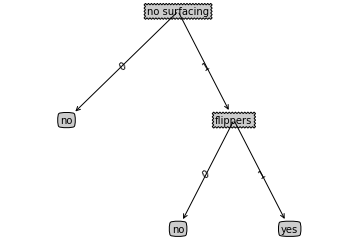

In [85]:
createPlot(decisionTree)

### 预测眼镜类型

In [90]:
file = open('./lenses.txt')
content = file.readlines()
lenses = [line.strip().split('\t') for line in content]
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
lensesTree = createTree(lenses, lensesLabels)
lensesTree

{'tearRate': {'normal': {'astigmatic': {'yes': {'prescript': {'hyper': {'age': {'presbyopic': 'no lenses',
        'pre': 'no lenses',
        'young': 'hard'}},
      'myope': 'hard'}},
    'no': {'age': {'presbyopic': {'prescript': {'hyper': 'soft',
        'myope': 'no lenses'}},
      'pre': 'soft',
      'young': 'soft'}}}},
  'reduced': 'no lenses'}}

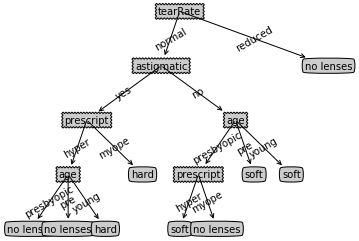

In [91]:
createPlot(lensesTree)